# Data Loading and preprocessing

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

DATA_DIR = "Audio_Speech_Actors_01-24"
EMOTIONS = {'01':'neutral','02':'calm','03':'happy','04':'sad',
            '05':'angry','06':'fearful','07':'disgust','08':'surprised'}

In [4]:
def extract_features(file_path):
    signal, sr = librosa.load(file_path, sr=22050)

    mfccs = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=signal, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(signal), sr=sr).T, axis=0)

    return np.hstack([mfccs, chroma, zcr, contrast, tonnetz])


records = []
for actor_folder in os.listdir(DATA_DIR):
    p = os.path.join(DATA_DIR, actor_folder)
    for file in tqdm(os.listdir(p)):
        emotion = EMOTIONS[file.split('-')[2]]
        feat = extract_features(os.path.join(p, file))
        records.append([file, emotion, *feat])

# Automatically assign column names based on number of features
cols = ['file','emotion'] + [f'feature{i+1}' for i in range(len(records[0]) - 2)]
df = pd.DataFrame(records, columns=cols)


  0%|          | 0/60 [00:00<?, ?it/s]

c:\Users\dell\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\dell\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\dell\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
 12%|█▏        | 7/60 [00:01<00:09,  5.41it/s]c:\Users\dell\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(


# Preparing Data For traning

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = df.iloc[:, 2:].values
y = df['emotion'].values

le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(y))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc)


# Building the ANN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

num_classes = y_enc.shape[1]
input_dim = X_train.shape[1]

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


c:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1493 - loss: 2.0962 - val_accuracy: 0.2554 - val_loss: 1.8718
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3356 - loss: 1.7830 - val_accuracy: 0.3983 - val_loss: 1.6284
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4050 - loss: 1.5776 - val_accuracy: 0.3983 - val_loss: 1.5583
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5258 - loss: 1.3735 - val_accuracy: 0.4502 - val_loss: 1.4358
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5488 - loss: 1.2363 - val_accuracy: 0.4372 - val_loss: 1.3719
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6034 - loss: 1.1237 - val_accuracy: 0.4719 - val_loss: 1.3996
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6315 - loss: 1.0256 - val_accuracy: 0.4892 - val_loss: 1.2881
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6437 - loss: 0.9549 - val_accuracy: 0.5108 - val_loss: 1.2477
Epo

# Evaluate the Model

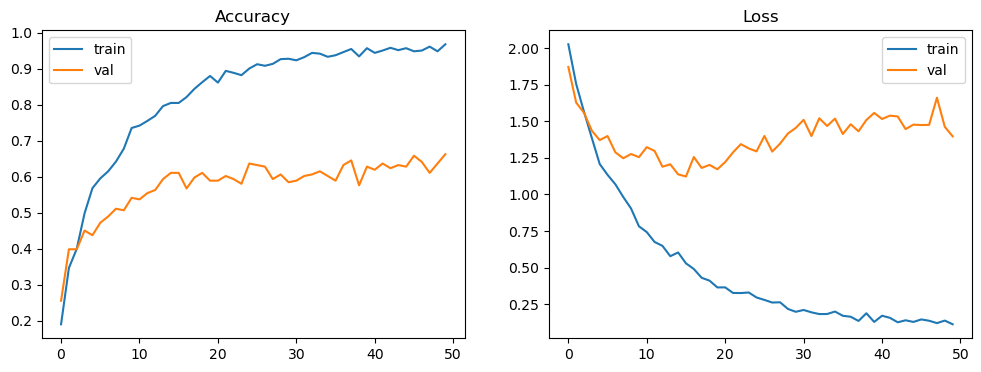

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

       angry       0.90      0.69      0.78        39
        calm       0.55      0.74      0.63        38
     disgust       0.68      0.67      0.68        39
     fearful       0.58      0.79      0.67        39
       happy       0.68      0.55      0.61        38
     neutral       0.53      0.47      0.50        19
         sad       0.58      0.39      0.47        38
   surprised       0.71      0.79      0.75        38

    accuracy                           0.65       288
   macro avg       0.65      0.64      0.64       288
weighted avg       0.66      0.65      0.65       288



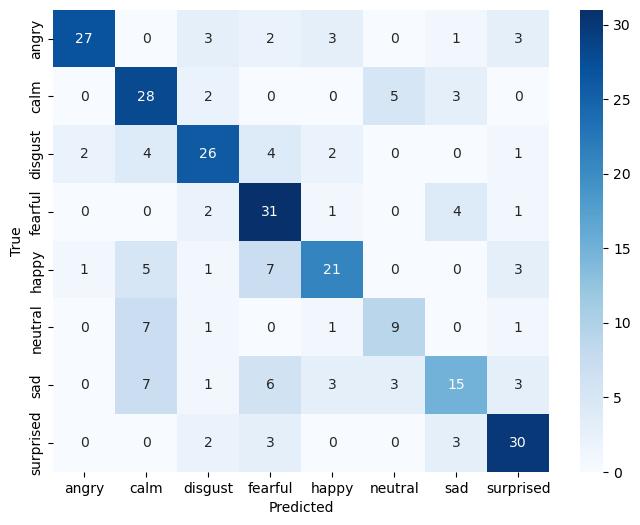

In [7]:
# import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()
plt.show()

# Test set evaluation
y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=le.classes_, yticklabels=le.classes_,
            annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

In [8]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 64.93%


In [9]:
model.save("ser_ravdess_model.h5")

# def predict_emotion(file_path):
#     feat = extract_features(file_path)
#     scaled = scaler.transform([feat])
#     pred = model.predict(scaled)
#     return le.inverse_transform([np.argmax(pred)])[0]

# # Example usage:
# print(predict_emotion("test_samples/happy01.wav"))


In [10]:
import pickle

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


# Deplyoment 

In [11]:
import gradio as gr
import librosa
import numpy as np
import tensorflow as tf
import pickle

# Load model
model = tf.keras.models.load_model('C:\\Users\\dell\\Pictures\\Shrunk\\GU sem 3\\Speech Emotion Recognition\\ser_ravdess_model.h5')

# Load scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load label encoder
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Feature extraction
def extract_features(file_path):
    signal, sr = librosa.load(file_path, sr=22050)
    mfccs = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=signal, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(signal), sr=sr).T, axis=0)
    return np.hstack([mfccs, chroma, zcr, contrast, tonnetz])

# Prediction function
def predict_emotion(audio):
    features = extract_features(audio)
    features_scaled = scaler.transform([features])
    prediction = model.predict(features_scaled)
    predicted_label = le.inverse_transform([np.argmax(prediction)])
    return f"Predicted Emotion: {predicted_label[0]}"

# Gradio UI
interface = gr.Interface(fn=predict_emotion,
                         inputs=gr.Audio(type="filepath"),
                         outputs="text",
                         title="Speech Emotion Recognition")

interface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
